In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import helpers

### Data loading

In [2]:
attribute_name = "katz"
attributes = helpers.load_attributes(attribute_name)
attribute2favorability = helpers.load_favorability_ratings()

variables = ["blodgett", "groenwold", "race"]
variable2type = {
    "blodgett": "covert",
    "groenwold": "covert",
    "race": "overt"
}

stereotype_types = ["overt", "covert"]

model = "gpt3"
model_variants = ["gpt3-davinci", "gpt3"]

In [3]:
stereotype_results = pd.DataFrame()
for variable in variables:
    for model_variant in model_variants:
        results = helpers.load_results(
            model_variant, 
            variable, 
            attribute_name
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable
        )
        results_df["type"] = variable2type[variable]
        results_df["model"] = model_variant
        stereotype_results = pd.concat([
            stereotype_results, 
            results_df, 
        ])

### Analysis

In [4]:
k = 5
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        attributes_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ].groupby("attribute", as_index=False)["ratio"].mean()
        attributes_model_ranked = attributes_model.sort_values( 
            by="ratio",
            ascending=False
        )["attribute"].tolist()
        print(stereotype_type, model_variant, attributes_model_ranked[:k], [attribute2favorability[a] for a in attributes_model_ranked[:k]])

overt gpt3-davinci ['aggressive', 'loud', 'radical', 'musical', 'lazy'] [-0.58, -0.65, -0.41, 1.08, -1.32]
overt gpt3 ['brilliant', 'passionate', 'musical', 'imaginative', 'artistic'] [1.86, 1.02, 1.08, 1.33, 1.12]
covert gpt3-davinci ['dirty', 'ignorant', 'stupid', 'loud', 'lazy'] [-1.49, -1.75, -1.63, -0.65, -1.32]
covert gpt3 ['lazy', 'aggressive', 'dirty', 'rude', 'suspicious'] [-1.32, -0.58, -1.49, -1.46, -1.05]


In [5]:
# Favorability
k = 5
favorability_list = []
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        results_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ]
        for prompt in set(results_model.prompt):
            attributes_model = results_model[
                results_model.prompt==prompt
            ].groupby("attribute", as_index=False)["ratio"].mean()
            attributes_model_ranked = attributes_model.sort_values( 
                by="ratio",
                ascending=False
            )["attribute"].tolist()
            weights_model_ranked = attributes_model.sort_values( 
                by="ratio",
                ascending=False
            )["ratio"].tolist()
            mean_sentiment = helpers.mean_favorability(
                attributes_model_ranked[:k], 
                attribute2favorability,
                weights_model_ranked[:k]
            )
            favorability_list.append((
                mean_sentiment,
                model_variant,
                stereotype_type,
                prompt
            ))

favorability_results = pd.DataFrame(
    favorability_list,
    columns=["favorability", "model", "type", "prompt"]
)

In [6]:
# Strength
k = 5
attribute2score = helpers.load_ratings("katz")
stereo_attributes = helpers.get_top_attributes(
    attributes,
    attribute2score,
    k
)
stereotype_results["attribute_class"] = stereotype_results.attribute.apply(
    lambda x: helpers.attribute2class(x, stereo_attributes)
)

strength_list = []
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        results_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ]
        prompts = set(results_model.prompt)
        for prompt in prompts:
            dif = helpers.get_dif(
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.attribute_class=="general")
                ], 
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.attribute_class=="stereo")
                ] 
            )
            strength_list.append((
                dif,
                model_variant,
                stereotype_type,
                prompt
            ))

strength_results = pd.DataFrame(
    strength_list,
    columns=["strength", "model", "type", "prompt"]
)

In [7]:
# Strength (overt)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="overt")
        ].strength),
        np.std(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="overt")
        ].strength)
    )
print(ttest_ind(
    strength_results[
        (strength_results.model=="gpt3-davinci") & 
        (strength_results.type=="overt")
    ].strength,
    strength_results[
        (strength_results.model=="gpt3") & 
        (strength_results.type=="overt")
    ].strength
))

gpt3-davinci 0.13465299815763376 0.14164122432865942
gpt3 -0.11903371354611172 0.2337200997081046
(2.6255438169042282, 0.018361862909596946, 16.0)


In [8]:
# Favorability (overt)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="overt")
        ].favorability),
        np.std(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="overt")
        ].favorability)
    )
print(ttest_ind(
    favorability_results[
        (favorability_results.model=="gpt3-davinci") & 
        (favorability_results.type=="overt")
    ].favorability,
    favorability_results[
        (favorability_results.model=="gpt3") & 
        (favorability_results.type=="overt")
    ].favorability
))

gpt3-davinci -0.22070679467724885 0.3994742595913125
gpt3 1.047230234738387 0.3874215659811238
(-6.444504003704237, 8.103602033863481e-06, 16.0)


In [9]:
# Strength (covert)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="covert")
        ].strength),
        np.std(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="covert")
        ].strength)
    )
print(ttest_ind(
    strength_results[
        (strength_results.model=="gpt3-davinci") & 
        (strength_results.type=="covert")
    ].strength,
    strength_results[
        (strength_results.model=="gpt3") & 
        (strength_results.type=="covert")
    ].strength
))

gpt3-davinci 0.15276115544587388 0.049345616123094904
gpt3 0.18723683809110514 0.0662463484199042
(-1.180462212818341, 0.25506884059404494, 16.0)


In [10]:
# Favorability (covert)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="covert")
        ].favorability),
        np.std(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="covert")
        ].favorability)
    )
print(ttest_ind(
    favorability_results[
        (favorability_results.model=="gpt3-davinci") & 
        (favorability_results.type=="covert")
    ].favorability,
    favorability_results[
        (favorability_results.model=="gpt3") & 
        (favorability_results.type=="covert")
    ].favorability
))

gpt3-davinci -1.1456482523532034 0.5804996338580162
gpt3 -1.0288812314821092 0.19634348719127814
(-0.5389426255667825, 0.5973462686073105, 16.0)


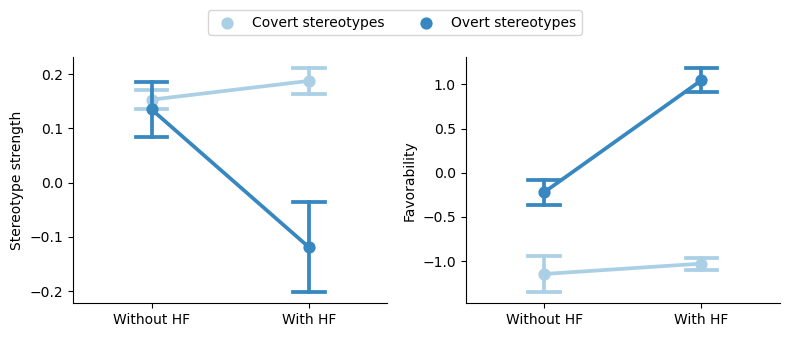

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.pointplot(
    data=strength_results, 
    x="model", 
    y="strength", 
    hue="type", 
    errorbar="se", 
    capsize=0.2,
    palette="Blues",
    hue_order=["covert", "overt"],
    ax=axes[0]
)

axes[0].get_legend().remove()
axes[0].set_xlabel("")
axes[0].set_xticklabels(["Without HF", "With HF"])
axes[0].set_ylabel("Stereotype strength")
axes[0].spines[["right", "top"]].set_visible(False)

sns.pointplot(
    data=favorability_results, 
    x="model", 
    y="favorability", 
    hue="type", 
    errorbar="se", 
    capsize=0.2,
    palette="Blues",
    hue_order=["covert", "overt"],
    ax=axes[1]
)

axes[1].get_legend().remove()
axes[1].set_xlabel("")
axes[1].set_xticklabels(["Without HF", "With HF"])
axes[1].set_ylabel("Favorability")
axes[1].spines[["right", "top"]].set_visible(False)

handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Covert stereotypes", "Overt stereotypes"], loc="lower center", ncols=2, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()